<a href="https://colab.research.google.com/github/Gail529/chess_ML/blob/main/trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install category_encoders

     |████████████████████████████████| 81kB 3.6MB/s 


In [17]:
#required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics 
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import warnings
import category_encoders as ce
from category_encoders.hashing import HashingEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import LabelEncoder 
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings(action='ignore')
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=RuntimeWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)



In [30]:
data=pd.read_csv('/content/games.csv',usecols=['turns','winner','white_rating','black_rating','opening_ply','opening_eco','increment_code'])
data.head()

,turns,winner,increment_code,white_rating,black_rating,opening_eco,opening_ply
0,13,white,15+2,1500,1191,D10,5
1,16,black,5+10,1322,1261,B00,4
2,61,white,5+10,1496,1500,C20,3
3,61,white,20+0,1439,1454,D02,3
4,95,white,30+3,1523,1469,C41,5


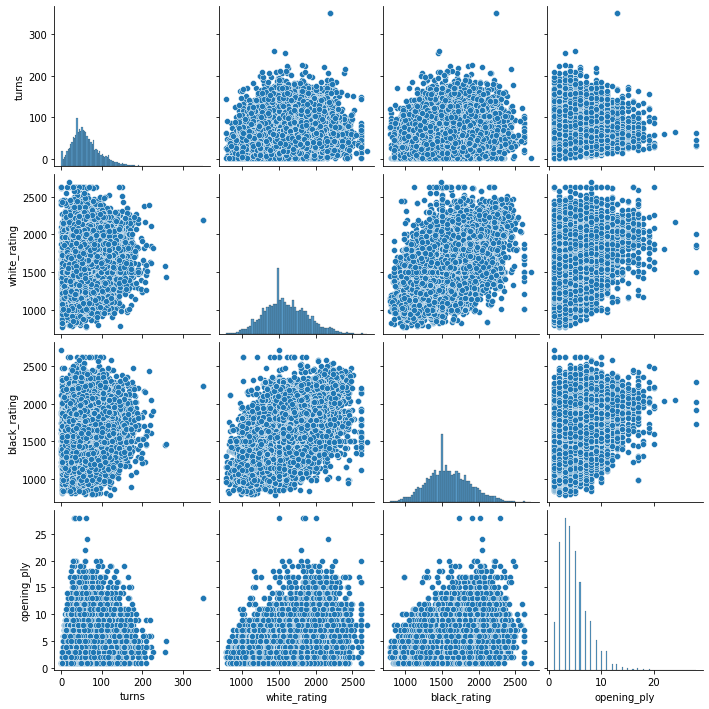

In [31]:
sns.pairplot(data)

# Feature Engineering
feature generation

In [32]:
#creating a new feature
data['rating_diff'] = data['white_rating']-data['black_rating']
data.columns


Index(['turns', 'winner', 'increment_code', 'white_rating', 'black_rating',
       'opening_eco', 'opening_ply', 'rating_diff'],
      dtype='object')

Dropping null values


In [33]:
data.isnull().sum().sum()
data.dropna(axis=0,inplace=True)

Feature Scaling

In [34]:
#standardisation
from sklearn import preprocessing 
cols=['turns','white_rating', 'black_rating', 'opening_ply','rating_diff']
cols_to_scale=data[cols]
Standardisation = preprocessing.StandardScaler()  
scaled_cols= Standardisation.fit_transform(cols_to_scale) 
print ("\nStandardised columns : \n", scaled_cols) 
data[cols]=scaled_cols



Standardised columns : 
 [[-1.4139516  -0.33178766 -1.36698461  0.0654322   1.20949108]
 [-1.32458542 -0.94295461 -1.12645864 -0.29208323  0.21362897]
 [ 0.01590722 -0.34552175 -0.30523428 -0.64959865 -0.04738328]
 ...
 [-0.75859964 -1.2966074  -1.04055651 -0.64959865 -0.30036438]
 [ 1.44576604 -0.81248077 -1.24328554 -0.29208323  0.50275023]
 [ 0.52231555 -1.24167104 -0.858444   -0.64959865 -0.44894059]]


# Encoding categorical  variables

Using binary encoder

In [ ]:
# label encoding the data 
categorical_feature_mask = data.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = data.columns[categorical_feature_mask].tolist()
print(categorical_cols)
le = LabelEncoder() 
data['winner']= le.fit_transform(data['winner'])
data['rated']= le.fit_transform(data['rated'])
data['victory_status']= le.fit_transform(data['rated'])

#for categorical_cols with high cardinality
#binary encoding
encoder= ce.BinaryEncoder(cols=['opening_eco','increment_code'])
data_encoded=encoder.fit_transform(data) 

['victory_status', 'winner', 'increment_code', 'opening_eco']


Using frequency encoding

In [36]:
# label encoding the data 
categorical_feature_mask = data.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = data.columns[categorical_feature_mask].tolist()
print(categorical_cols)
le = LabelEncoder() 
data['winner']= le.fit_transform(data['winner'])


#frequency encoding for the categorical_cols with high cardinality
fe1= data.groupby('opening_eco').size()/len(data)
data.loc[:,'opening_encode']=data['opening_eco'].map(fe1)
fe_data=data.drop(columns=['opening_eco'],axis=1)


fe2= data.groupby('increment_code').size()/len(data)
data.loc[:,'incr_encode']=data['increment_code'].map(fe2)
fe_data=fe_data.drop(columns=['increment_code'],axis=1)



['increment_code', 'opening_eco']


# Feature Importance using RANDOM FOREST




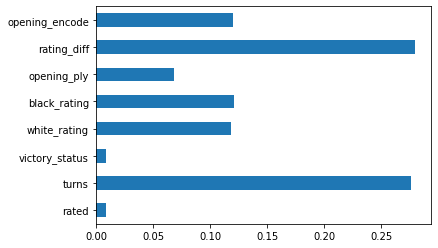

In [29]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
rf.feature_importances_
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.plot(kind='barh')


In [ ]:
X = data_encoded.drop(columns=['winner'], axis=1)
y = data_encoded['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [37]:
X = fe_data.drop(columns=['winner'], axis=1)
y = fe_data['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [38]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(max_depth=13,criterion='gini')
# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)
#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",clf.score(X_test, y_test))
print("Accuracy:",clf.score(X_train, y_train))


Accuracy: 0.6326021934197408
Accuracy: 0.7130125888071793


In [40]:
import numpy as np
def dtree_grid_search(X,y,nfolds):
    #create a dictionary of all values we want to test
    param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(1, 15)}
    # decision tree model
    dtree_model=DecisionTreeClassifier()
    #use gridsearch to test all values
    dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=nfolds)
    #fit model to data
    dtree_gscv.fit(X, y)
    return dtree_gscv.best_params_

dtree_grid_search(X,y,10)

{'criterion': 'entropy', 'max_depth': 13}

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))

Accuracy: 0.6321036889332003
              precision    recall  f1-score   support

           0       0.65      0.55      0.60      1816
           1       0.14      0.06      0.08       192
           2       0.64      0.76      0.69      2004

    accuracy                           0.63      4012
   macro avg       0.48      0.46      0.46      4012
weighted avg       0.62      0.63      0.62      4012



In [39]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred))


Accuracy: 0.6555333998005982
              precision    recall  f1-score   support

           0       0.64      0.65      0.64      1816
           1       0.65      0.09      0.16       192
           2       0.67      0.72      0.69      2004

    accuracy                           0.66      4012
   macro avg       0.65      0.48      0.50      4012
weighted avg       0.66      0.66      0.64      4012

